# 🧠 Red Neuronal Simple - Clasificación de Imágenes OCT
## Red Neuronal Mínima para Clasificación Multiclase

---

En este notebook aplicaremos una **red neuronal simple** con el mínimo de capas y parámetros posible para clasificar imágenes OCT retinales.

### 📦 Dataset:
- **Fuente:** Kermany et al. 2018 Mendeley Data V3
- **Total:** 109,309 imágenes JPEG
- **Split:** 70% train (~76,500), 20% val (~21,900), 10% test (~10,900)
- **Clases:** CNV, DME, DRUSEN, NORMAL

### 🎯 Características de la Red Neuronal:
- **Tipo:** Red neuronal feedforward con 1 capa oculta
- **Arquitectura:** Flatten → Dense(32, ReLU) → Dense(4, Softmax)
- **Parámetros:** ~131,236 (mínimo posible)
- **Entrada:** Imágenes 64×64 en escala de grises (4,096 píxeles)
- **Ventajas:** Muy rápida, pocas operaciones, bajo consumo de memoria
- **Optimización de memoria:** Imágenes en escala de grises para reducir 3× el uso de RAM/GPU
- **Subset de datos:** Usaremos 40% del train para optimizar memoria y tiempo

---

## 1. 📥 Carga de Datos con Data Loaders

Primero cargamos los datos usando los data loaders que ya configuramos.

In [1]:
# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================================
import os

# Silenciar logs informativos de TensorFlow (debe ir antes de importar tf)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# ============================================================================
# CONFIGURACIÓN DE MEMORIA GPU
# ============================================================================
# Configurar TensorFlow para liberar memoria y no cargar todo en GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Habilitar memory growth (asignar memoria según se necesite)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ {len(gpus)} GPU(s) configuradas con memory growth")
    except RuntimeError as e:
        print(f"⚠️  Error configurando GPUs: {e}")

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Importar módulo de dataloaders (solo si se ejecuta localmente)
try:
    import oct_dataloader as dataloaders
    print("✅ Módulo oct_dataloader importado (ejecución local)")
except ImportError:
    print("⚠️  oct_dataloader no encontrado - usar funciones embebidas para Colab")
    dataloaders = None

# Importar modelo de red neuronal
try:
    import modelo_simple_nn as nn_model
    print("✅ Módulo modelo_simple_nn importado (ejecución local)")
except ImportError:
    print("⚠️  modelo_simple_nn no encontrado - se definirá en el notebook")
    nn_model = None

# Configuración
np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")

✅ 4 GPU(s) configuradas con memory growth
✅ Módulo oct_dataloader importado (ejecución local)
✅ Módulo modelo_simple_nn importado (ejecución local)
✅ Librerías importadas correctamente


### 📝 Nota para Google Colab:
Si ejecutas este notebook en **Google Colab**, ejecuta la celda siguiente para definir las funciones necesarias del dataloader y el modelo.

Si ejecutas **localmente** (tienes los archivos `oct_dataloader.py` y `modelo_simple_nn.py`), puedes saltarte la siguiente celda.

In [2]:
# ============================================================================
# FUNCIONES EMBEBIDAS (PARA GOOGLE COLAB)
# ============================================================================
# Solo ejecuta esta celda si estás en Colab

if dataloaders is None:
    from typing import Tuple, Optional
    
    class dataloaders:
        @staticmethod
        def create_oct_dataloaders(
            data_path: str,
            img_size: Tuple[int, int] = (224, 224),
            batch_size: int = 32,
            train_subset_fraction: float = 1.0,
            seed: int = 42,
            validation_split: Optional[float] = None,
            optimize: bool = True,
            verbose: bool = True
        ):
            """Crea dataloaders para el dataset OCT con configuración flexible."""
            
            class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
            
            if verbose:
                print("⚙️ Configuración de DataLoaders")
                print(f"   • Tamaño de imagen: {img_size}")
                print(f"   • Batch size: {batch_size}")
                print(f"   • Clases: {class_names}")
                print(f"   • Train subset: {train_subset_fraction*100:.1f}%")
                print(f"   • Seed: {seed}\n")
            
            # DATA LOADER DE ENTRENAMIENTO
            train_path = os.path.join(data_path, 'train')
            
            if not os.path.exists(train_path):
                raise ValueError(f"No se encontró la carpeta de entrenamiento en: {train_path}")
            
            if verbose:
                print("📦 Creando data loader de entrenamiento...")
            
            train_dataset = tf.keras.utils.image_dataset_from_directory(
                train_path,
                labels='inferred',
                label_mode='int',
                class_names=class_names,
                color_mode='grayscale',
                batch_size=batch_size,
                image_size=img_size,
                shuffle=True,
                seed=seed
            )
            
            if train_subset_fraction < 1.0:
                total_batches = tf.data.experimental.cardinality(train_dataset).numpy()
                subset_batches = max(1, int(total_batches * train_subset_fraction))
                train_dataset = train_dataset.take(subset_batches)
                
                if verbose:
                    print(f"   ⚠️  Usando {train_subset_fraction*100:.1f}% del dataset de entrenamiento")
                    print(f"   ⚠️  Batches: {subset_batches} de {total_batches}")
            
            if optimize:
                train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
                if verbose:
                    print(f"✅ Data loader de entrenamiento creado (con optimización)")
            else:
                if verbose:
                    print(f"✅ Data loader de entrenamiento creado")
            
            # DATA LOADER DE VALIDACIÓN
            val_path = os.path.join(data_path, 'val')
            val_dataset = None
            
            if os.path.exists(val_path):
                if verbose:
                    print("\n📦 Creando data loader de validación...")
                
                val_dataset = tf.keras.utils.image_dataset_from_directory(
                    val_path,
                    labels='inferred',
                    label_mode='int',
                    class_names=class_names,
                    color_mode='grayscale',
                    batch_size=batch_size,
                    image_size=img_size,
                    shuffle=False
                )
                
                if optimize:
                    val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
                    if verbose:
                        print(f"✅ Data loader de validación creado (con optimización)")
                else:
                    if verbose:
                        print(f"✅ Data loader de validación creado")
            
            # DATA LOADER DE PRUEBA
            test_path = os.path.join(data_path, 'test')
            test_dataset = None
            
            if os.path.exists(test_path):
                if verbose:
                    print("\n📦 Creando data loader de prueba...")
                
                test_dataset = tf.keras.utils.image_dataset_from_directory(
                    test_path,
                    labels='inferred',
                    label_mode='int',
                    class_names=class_names,
                    color_mode='grayscale',
                    batch_size=batch_size,
                    image_size=img_size,
                    shuffle=False
                )
                
                if optimize:
                    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
                    if verbose:
                        print(f"✅ Data loader de prueba creado (con optimización)")
                else:
                    if verbose:
                        print(f"✅ Data loader de prueba creado")
            
            if verbose:
                print("\n" + "="*60)
                print("📊 RESUMEN DE DATASETS")
                print("="*60)
                
                if train_dataset:
                    train_cardinality = tf.data.experimental.cardinality(train_dataset).numpy()
                    print(f"Train:      {train_cardinality} batches")
                
                if val_dataset:
                    val_cardinality = tf.data.experimental.cardinality(val_dataset).numpy()
                    print(f"Validation: {val_cardinality} batches")
                
                if test_dataset:
                    test_cardinality = tf.data.experimental.cardinality(test_dataset).numpy()
                    print(f"Test:       {test_cardinality} batches")
                
                print("="*60 + "\n")
            
            return train_dataset, val_dataset, test_dataset, class_names
    
    print("✅ Funciones de dataloader cargadas para Colab")

if nn_model is None:
    from tensorflow import keras
    from tensorflow.keras import layers
    
    class nn_model:
        @staticmethod
        def create_simple_nn(input_shape=(64, 64, 1), num_classes=4, hidden_units=32):
            """Crea una red neuronal simple con el mínimo de capas."""
            
            model = keras.Sequential([
                layers.Input(shape=input_shape),
                layers.Flatten(),
                layers.Dense(hidden_units, activation='relu', name='hidden'),
                layers.Dense(num_classes, activation='softmax', name='output')
            ], name='SimpleNN')
            
            return model
        
        @staticmethod
        def compile_model(model, learning_rate=0.001):
            """Compila el modelo con optimizador y función de pérdida."""
            
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            
            return model
        
        @staticmethod
        def print_model_summary(model):
            """Imprime un resumen detallado del modelo."""
            
            print("\n" + "=" * 70)
            print(" " * 20 + "📊 ARQUITECTURA DEL MODELO")
            print("=" * 70)
            
            model.summary()
            
            total_params = model.count_params()
            trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
            
            print("\n" + "=" * 70)
            print("📈 RESUMEN DE PARÁMETROS")
            print("=" * 70)
            print(f"   • Parámetros totales: {total_params:,}")
            print(f"   • Parámetros entrenables: {trainable_params:,}")
            print(f"   • Capas: {len(model.layers)}")
            print("=" * 70 + "\n")
    
    print("✅ Funciones de modelo cargadas para Colab")
else:
    print("ℹ️  Usando módulos locales (oct_dataloader.py y modelo_simple_nn.py)")

ℹ️  Usando módulos locales (oct_dataloader.py y modelo_simple_nn.py)


In [3]:
# ============================================================================
# CARGAR DATASET CON KAGGLEHUB
# ============================================================================
import kagglehub

# Descargar dataset
path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print(f"📦 Dataset descargado en: {path}")

# Buscar la estructura correcta del dataset
data_path = path
for root, dirs, files in os.walk(path):
    if 'train' in dirs and 'test' in dirs:
        data_path = root
        print(f"✅ Estructura de datos encontrada en: {data_path}")
        break

# Verificar carpetas
if os.path.exists(os.path.join(data_path, 'train')):
    print(f"   ✓ Carpeta train encontrada")
if os.path.exists(os.path.join(data_path, 'val')):
    print(f"   ✓ Carpeta val encontrada")
if os.path.exists(os.path.join(data_path, 'test')):
    print(f"   ✓ Carpeta test encontrada")

📦 Dataset descargado en: /home/palodo2/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2
✅ Estructura de datos encontrada en: /home/palodo2/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2/Dataset - train+val+test
   ✓ Carpeta train encontrada
   ✓ Carpeta val encontrada
   ✓ Carpeta test encontrada


## 2. ⚙️ Configuración de Data Loaders

Creamos los data loaders para cargar imágenes eficientemente en escala de grises.

In [4]:
# ============================================================================
# CONFIGURACIÓN DE DATA LOADERS
# ============================================================================

# Parámetros - Imágenes pequeñas en escala de grises
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

# Crear dataloaders - SIN cache para evitar llenar la GPU
train_dataset, val_dataset, test_dataset, class_names = dataloaders.create_oct_dataloaders(
    data_path=data_path,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    verbose=True,
    train_subset_fraction=0.4,  # 40% del train para optimizar memoria
    optimize=False  # Sin cache para no llenar GPU
)

print(f"\n✅ DataLoaders creados correctamente")
print(f"   Clases: {class_names}")
print(f"   Formato: Escala de grises (1 canal)")

⚙️ Configuración de DataLoaders
   • Tamaño de imagen: (64, 64)
   • Batch size: 32
   • Clases: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
   • Train subset: 40.0%
   • Seed: 42

📦 Creando data loader de entrenamiento...
Found 76515 files belonging to 4 classes.


I0000 00:00:1772216174.409185 2476643 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1114 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:05:00.0, compute capability: 9.0
I0000 00:00:1772216174.411571 2476643 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 77461 MB memory:  -> device: 1, name: NVIDIA H100 PCIe, pci bus id: 0000:09:00.0, compute capability: 9.0
I0000 00:00:1772216174.416902 2476643 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 77461 MB memory:  -> device: 2, name: NVIDIA H100 PCIe, pci bus id: 0000:8d:00.0, compute capability: 9.0
I0000 00:00:1772216174.419242 2476643 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 77461 MB memory:  -> device: 3, name: NVIDIA H100 PCIe, pci bus id: 0000:91:00.0, compute capability: 9.0
E0000 00:00:1772216174.546828 2477143 ptx_compiler_helpers.cc:88] *** WARNING *** Inv

   ⚠️  Usando 40.0% del dataset de entrenamiento
   ⚠️  Batches: 956 de 2392
✅ Data loader de entrenamiento creado

📦 Creando data loader de validación...
Found 21861 files belonging to 4 classes.
✅ Data loader de validación creado

📦 Creando data loader de prueba...
Found 10933 files belonging to 4 classes.
✅ Data loader de prueba creado

📊 RESUMEN DE DATASETS
Train:      956 batches
Validation: 684 batches
Test:       342 batches


✅ DataLoaders creados correctamente
   Clases: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
   Formato: Escala de grises (1 canal)


## 3. 🧠 Crear Red Neuronal

Creamos una red neuronal con el mínimo de capas y parámetros posible.

In [5]:
# ============================================================================
# CREAR RED NEURONAL SIMPLE
# ============================================================================

print("=" * 70)
print("🏗️  CREANDO RED NEURONAL SIMPLE")
print("=" * 70)

# Crear modelo
model = nn_model.create_simple_nn(
    input_shape=(64, 64, 1),  # Escala de grises
    num_classes=4,
    hidden_units=32  # Solo 32 neuronas en la capa oculta
)

# Compilar modelo
model = nn_model.compile_model(model, learning_rate=0.001)

# Mostrar resumen
nn_model.print_model_summary(model)

print("✅ Red neuronal creada y compilada")

🏗️  CREANDO RED NEURONAL SIMPLE

                    📊 ARQUITECTURA DEL MODELO


Model: "SimpleNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,236 (512.64 KB)

 Trainable params: 131,236 (512.64 KB)

 Non-trainable params: 0 (0.00 B)


📈 RESUMEN DE PARÁMETROS
   • Parámetros totales: 131,236
   • Parámetros entrenables: 131,236
   • Capas: 3

✅ Red neuronal creada y compilada


## 4. 🎓 Entrenamiento del Modelo

Entrenamos la red neuronal con los datos.

In [6]:
# ============================================================================
# ENTRENAR RED NEURONAL
# ============================================================================

print("=" * 70)
print("🚀 ENTRENANDO RED NEURONAL")
print("=" * 70)

# Configuración de entrenamiento
EPOCHS = 20

# Early stopping para evitar overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Callbacks
callbacks = [early_stopping]

# Entrenar modelo
print(f"\n📚 Entrenando por {EPOCHS} épocas máximo...")
print(f"   Early stopping habilitado (patience=5)\n")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Entrenamiento completado")

🚀 ENTRENANDO RED NEURONAL

📚 Entrenando por 20 épocas máximo...
   Early stopping habilitado (patience=5)

Epoch 1/20
 85/956 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4094 - loss: 25.0339

I0000 00:00:1772216177.337593 2477136 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


956/956 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4690 - loss: 1.7917 - val_accuracy: 0.4702 - val_loss: 1.1797
Epoch 2/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4718 - loss: 1.1728 - val_accuracy: 0.4702 - val_loss: 1.1648
Epoch 3/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4719 - loss: 1.1682 - val_accuracy: 0.4702 - val_loss: 1.1639
Epoch 4/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4715 - loss: 1.1683 - val_accuracy: 0.4702 - val_loss: 1.1638
Epoch 5/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4714 - loss: 1.1683 - val_accuracy: 0.4702 - val_loss: 1.1637
Epoch 6/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4714 - loss: 1.1682 - val_accuracy: 0.4702 - val_loss: 1.1638
Epoch 7/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4716 - loss: 1.1682 - val_accuracy: 0.4702 - val_loss: 1.1638
Epoch 8/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4716 - loss: 1.1682 - val_accuracy: 0.4702 - val_

## 5. 📈 Visualización del Entrenamiento

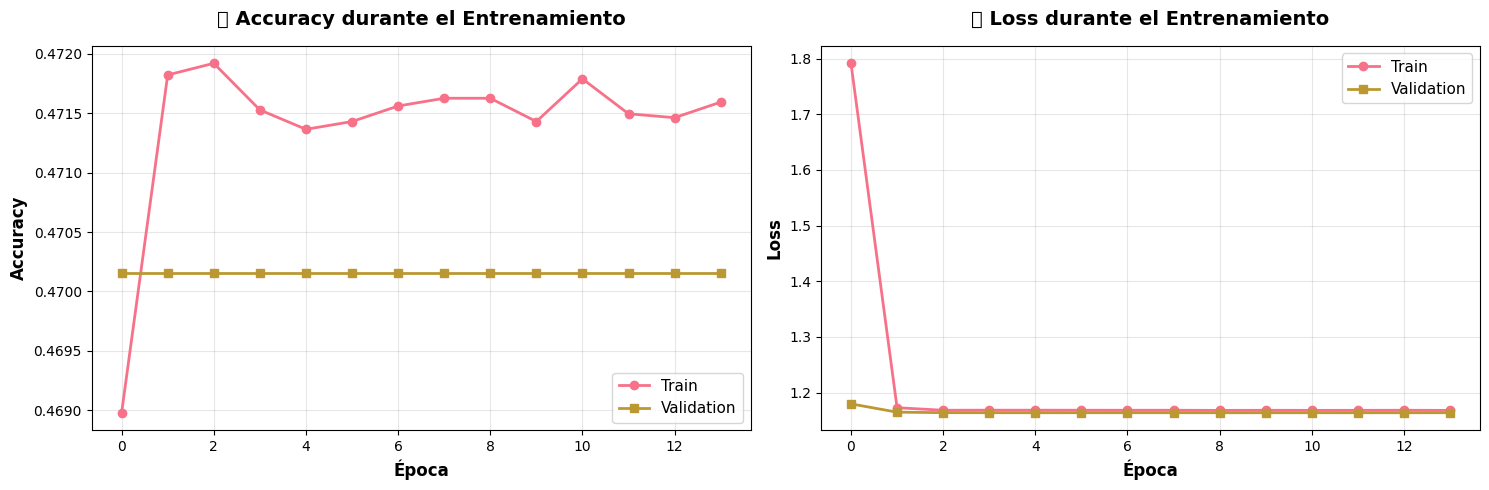


🏆 Mejor época: 9
   Acc Train: 0.4716
   Acc Val:   0.4702
   Loss Val:  1.1637


In [7]:
# ============================================================================
# GRÁFICOS DE ENTRENAMIENTO
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train', linewidth=2, marker='o')
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
ax1.set_xlabel('Época', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('📊 Accuracy durante el Entrenamiento', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Train', linewidth=2, marker='o')
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s')
ax2.set_xlabel('Época', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('📉 Loss durante el Entrenamiento', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Imprimir mejor época
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"\n🏆 Mejor época: {best_epoch}")
print(f"   Acc Train: {history.history['accuracy'][best_epoch-1]:.4f}")
print(f"   Acc Val:   {history.history['val_accuracy'][best_epoch-1]:.4f}")
print(f"   Loss Val:  {history.history['val_loss'][best_epoch-1]:.4f}")

## 6. 📊 Evaluación del Modelo

Evaluamos el modelo en los tres conjuntos: entrenamiento, validación y test.

In [8]:
# ============================================================================
# EVALUACIÓN EN LOS TRES CONJUNTOS
# ============================================================================

def evaluar_modelo(modelo, dataset, dataset_name):
    """Evalúa el modelo en un conjunto de datos."""
    
    print(f"\n{'=' * 70}")
    print(f"📊 EVALUACIÓN EN {dataset_name.upper()}")
    print('=' * 70)
    
    # Evaluar
    results = modelo.evaluate(dataset, verbose=0)
    loss = results[0]
    accuracy = results[1]
    
    print(f"\n✅ Loss: {loss:.4f}")
    print(f"✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Predicciones
    print(f"\n🔮 Generando predicciones...")
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        predictions = modelo.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Reporte de clasificación
    print(f"\n📋 Reporte de Clasificación:")
    print("-" * 70)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)
    
    return accuracy, y_true, y_pred

# Evaluar en los tres conjuntos
acc_train, y_true_train, y_pred_train = evaluar_modelo(model, train_dataset, "Entrenamiento")
acc_val, y_true_val, y_pred_val = evaluar_modelo(model, val_dataset, "Validación")
acc_test, y_true_test, y_pred_test = evaluar_modelo(model, test_dataset, "Test")


📊 EVALUACIÓN EN ENTRENAMIENTO

✅ Loss: 1.1684
✅ Accuracy: 0.4714 (47.14%)

🔮 Generando predicciones...

📋 Reporte de Clasificación:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         CNV     0.0000    0.0000    0.0000     10325
         DME     0.0000    0.0000    0.0000      3311
      DRUSEN     0.0000    0.0000    0.0000      2529
      NORMAL     0.4716    1.0000    0.6409     14427

    accuracy                         0.4716     30592
   macro avg     0.1179    0.2500    0.1602     30592
weighted avg     0.2224    0.4716    0.3023     30592


📊 EVALUACIÓN EN VALIDACIÓN

✅ Loss: 1.1637
✅ Accuracy: 0.4702 (47.02%)

🔮 Generando predicciones...

📋 Reporte de Clasificación:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         CNV     0.0000    0.0000    0.0000      7491
         DME     0.0000    0.0000    0.0000      23

## 7. 📊 Visualización de Resultados

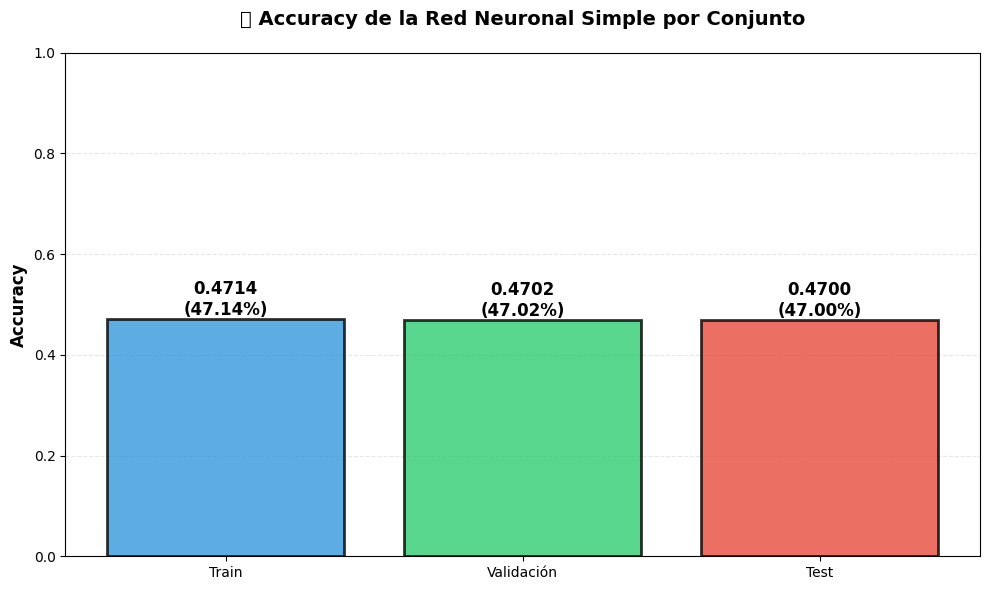

In [9]:
# ============================================================================
# GRÁFICO DE BARRAS CON ACCURACIES
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

conjuntos = ['Train', 'Validación', 'Test']
accuracies = [acc_train, acc_val, acc_test]
colores = ['#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(conjuntos, accuracies, color=colores, alpha=0.8, edgecolor='black', linewidth=2)

# Añadir valores sobre las barras
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}\n({acc*100:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('📊 Accuracy de la Red Neuronal Simple por Conjunto', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

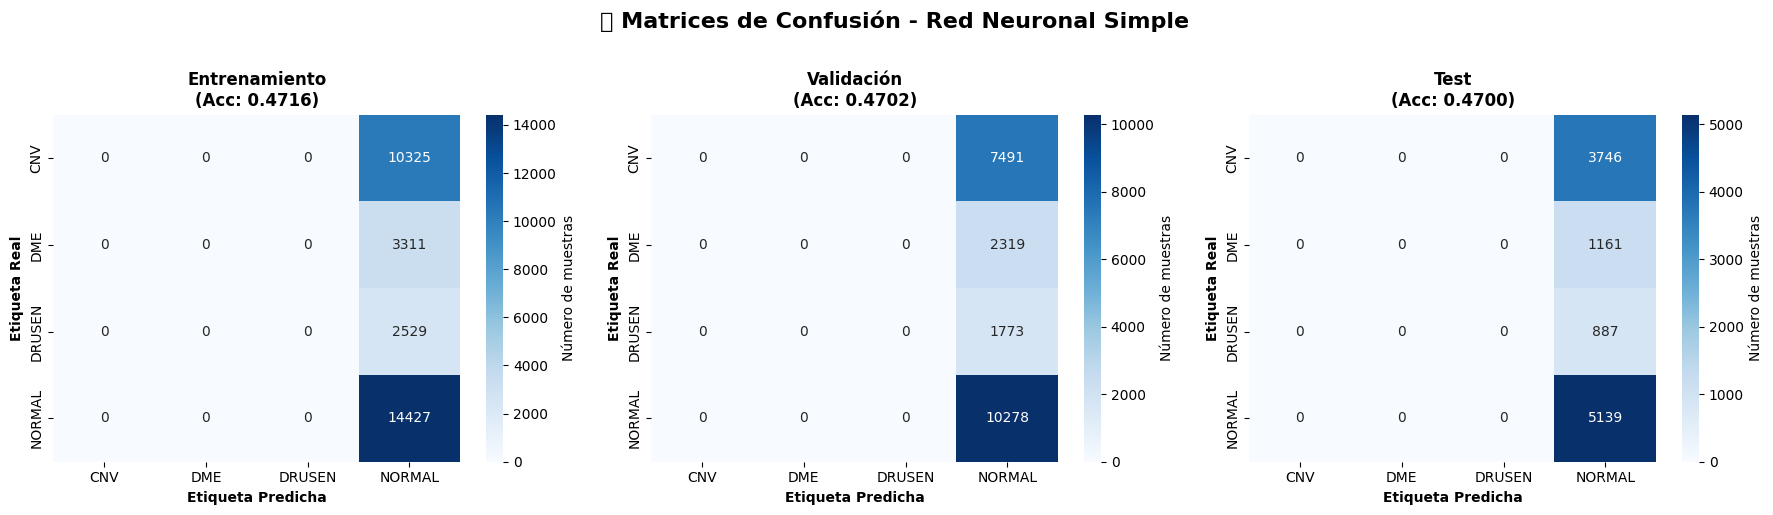

In [10]:
# ============================================================================
# MATRICES DE CONFUSIÓN
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('🔍 Matrices de Confusión - Red Neuronal Simple', fontsize=16, fontweight='bold', y=1.02)

datasets = [
    (y_true_train, y_pred_train, 'Entrenamiento', axes[0]),
    (y_true_val, y_pred_val, 'Validación', axes[1]),
    (y_true_test, y_pred_test, 'Test', axes[2])
]

for y_true, y_pred, titulo, ax in datasets:
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Número de muestras'})
    ax.set_title(f'{titulo}\n(Acc: {accuracy_score(y_true, y_pred):.4f})', 
                 fontweight='bold', fontsize=12)
    ax.set_ylabel('Etiqueta Real', fontweight='bold')
    ax.set_xlabel('Etiqueta Predicha', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 8. 📋 Tabla de Resultados Final

Resumen de los resultados para incluir en el README.

In [11]:
# ============================================================================
# CREAR TABLA DE RESULTADOS
# ============================================================================

print("\n" + "=" * 70)
print(" " * 20 + "📊 RESULTADOS FINALES")
print("=" * 70)

# Obtener número de parámetros
n_params = model.count_params()

# Calcular capas (sin contar Input y Flatten)
n_layers = len([layer for layer in model.layers if 'input' not in layer.name.lower() and 'flatten' not in layer.name.lower()])

resultados = {
    'Modelo': ['Red Neuronal Simple'],
    'Parámetros': [f'{n_params:,}'],
    'Capas': [n_layers],
    'Acc Train': [f'{acc_train:.4f}'],
    'Acc Validación': [f'{acc_val:.4f}'],
    'Acc Test': [f'{acc_test:.4f}']
}

df_resultados = pd.DataFrame(resultados)
print("\n")
print(df_resultados.to_string(index=False))
print("\n" + "=" * 70)

# Guardar también en formato markdown para el README
print("\n📄 Formato Markdown para README:")
print("\n```markdown")
print("| Modelo | Parámetros | Capas | Acc Train | Acc Validación | Acc Test |")
print("|--------|------------|-------|-----------|----------------|----------|")
print(f"| Red Neuronal Simple | {n_params:,} | {n_layers} | {acc_train:.4f} | {acc_val:.4f} | {acc_test:.4f} |")
print("```")


                    📊 RESULTADOS FINALES


             Modelo Parámetros  Capas Acc Train Acc Validación Acc Test
Red Neuronal Simple    131,236      2    0.4714         0.4702   0.4700


📄 Formato Markdown para README:

```markdown
| Modelo | Parámetros | Capas | Acc Train | Acc Validación | Acc Test |
|--------|------------|-------|-----------|----------------|----------|
| Red Neuronal Simple | 131,236 | 2 | 0.4714 | 0.4702 | 0.4700 |
```


---

## 10. 🎯 Conclusiones

### Comparación con otros modelos baseline:

| Modelo | Complejidad | Test Accuracy |
|--------|-------------|---------------|
| Modelo Lineal (Regresión Logística) | 49,156 parámetros | 0.6021 |
| Árbol de Decisión | 875 nodos (prof. 20) | 0.6027 |
| Red Neuronal Simple | ~131,236 parámetros | [Este modelo] |

